In [3]:

import numpy as np
from icecream import ic
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.optimize import least_squares, minimize
from scipy.interpolate import RectBivariateSpline

import speckle

width = 400
height = 400
pattern = speckle.Pattern(image_width=width,image_height=height, mean_radius=3, spacing=7, variability=0.6,stddev_size=0.1,gray_level=256,stddev_smooth=1.0,seed=1)
speckle_pattern = pattern.generate()

In [4]:

#-----------------------------------------------------------------------------------------------------------------------------
# subpixel roll
#-----------------------------------------------------------------------------------------------------------------------------


# copy the original pattern
deformed_pattern = speckle_pattern.copy()

#create interpolation
interp_x = interp_y = 4
subpx_samp = 1.0/interp_x
shift = 1

# pixel values of original images
orig_x = np.arange(speckle_pattern.shape[1])
orig_y = np.arange(speckle_pattern.shape[0])

# Pixel values of interpolated image
high_res_x = np.linspace(0, speckle_pattern.shape[1] - 1, (speckle_pattern.shape[1] - 1) * interp_x + 1)
high_res_y = np.linspace(0, speckle_pattern.shape[0] - 1, (speckle_pattern.shape[0] - 1) * interp_y + 1)

# interpolate the deformed pattern and shift the pixels using np.roll by the amount 'shift'
deformed_pattern_interp = speckle.correlation.spline_interpolation_image(deformed_pattern, interp_y, interp_x, 3)

split = deformed_pattern_interp.shape[0]


# Number of segments
num_segments = 4
shifts = [0, 1, 2, 3]  
segment_size = deformed_pattern_interp.shape[0] // num_segments

# Apply the shifts in a loop
for i in range(num_segments):
    start = i * segment_size
    end = (i + 1) * segment_size if i < num_segments - 1 else None  # Ensure last segment includes all remaining rows
    deformed_pattern_interp[start:end, :] = np.roll(deformed_pattern_interp[start:end, :], shift=shifts[i], axis=1)

# convert back to dimensions of original deformed_pattern
spline = RectBivariateSpline(high_res_y, high_res_x, deformed_pattern_interp)
deformed_pattern = spline(orig_y, orig_x)


#-----------------------------------------------------------------------------------------------------------------------------
# Stretching along rows (vertical direction) by a factor of 2
#-----------------------------------------------------------------------------------------------------------------------------

# deformed_image = zoom(speckle_pattern, (1, 2))
# deformed_image = deformed_image[:,0:200]
# arr = correlation.subset(speckle_pattern,x,y,subset_size)
# ic(arr.shape)
# ic(deformed_image.shape)

In [17]:

#-----------------------------------------------------------------------------------------------------------------------------
# DIC
#-----------------------------------------------------------------------------------------------------------------------------
bounds = [(-2, 2), (0,0), (0, 0), (0, 0), (0, 0), (0, 0)]  
u_arr1, v_arr1 = speckle.dic.reference_image_interpolation_minimizer(reference_image=speckle_pattern, deformed_image=deformed_pattern, bounds=bounds, subset_size=21, subset_step=10, interpolation=interp_x, corr_crit="ssd")
u_arr2, v_arr2 = speckle.dic.reference_image_interpolation_roi_gridsearch(reference_image=speckle_pattern, deformed_image=deformed_pattern, subset_size=21, subset_step=10, subset_search_radius=2.0, interpolation=interp_x, corr_crit="ssd")
u_arr3, v_arr3 = speckle.dic.global_spline_interpolation(reference_image=speckle_pattern, deformed_image=deformed_pattern, subset_size=21, subset_step=10, interpolation=interp_x, corr_crit="ssd")
u_arr4, v_arr4 = speckle.dic.local_correlation_interpolation(reference_image=speckle_pattern, deformed_image=deformed_pattern, subset_size=21, subset_step=10, interpolation=interp_x, correlation_roi_radius=3, corr_crit="ssd")


Searching for deformed subsets in the interpolated reference image using scipy.optimize.minimize                                                      : 100%|██████████| 1296/1296 [00:10<00:00, 125.28it/s]
Searching for deformed subsets in the interpolated reference image using a grid search within user specified search radius                            : 100%|██████████| 1296/1296 [00:15<00:00, 82.34it/s]
Searching for interpolated deformed subsets GLOBALLY in interpolated reference image using openCV                                                     : 100%|██████████| 1296/1296 [00:46<00:00, 28.12it/s]
Searching for deformed subsets GLOBALLY in the reference image. Interpolate the correlation to find subpixel shift:                                   : 100%|██████████| 1296/1296 [00:02<00:00, 455.10it/s]


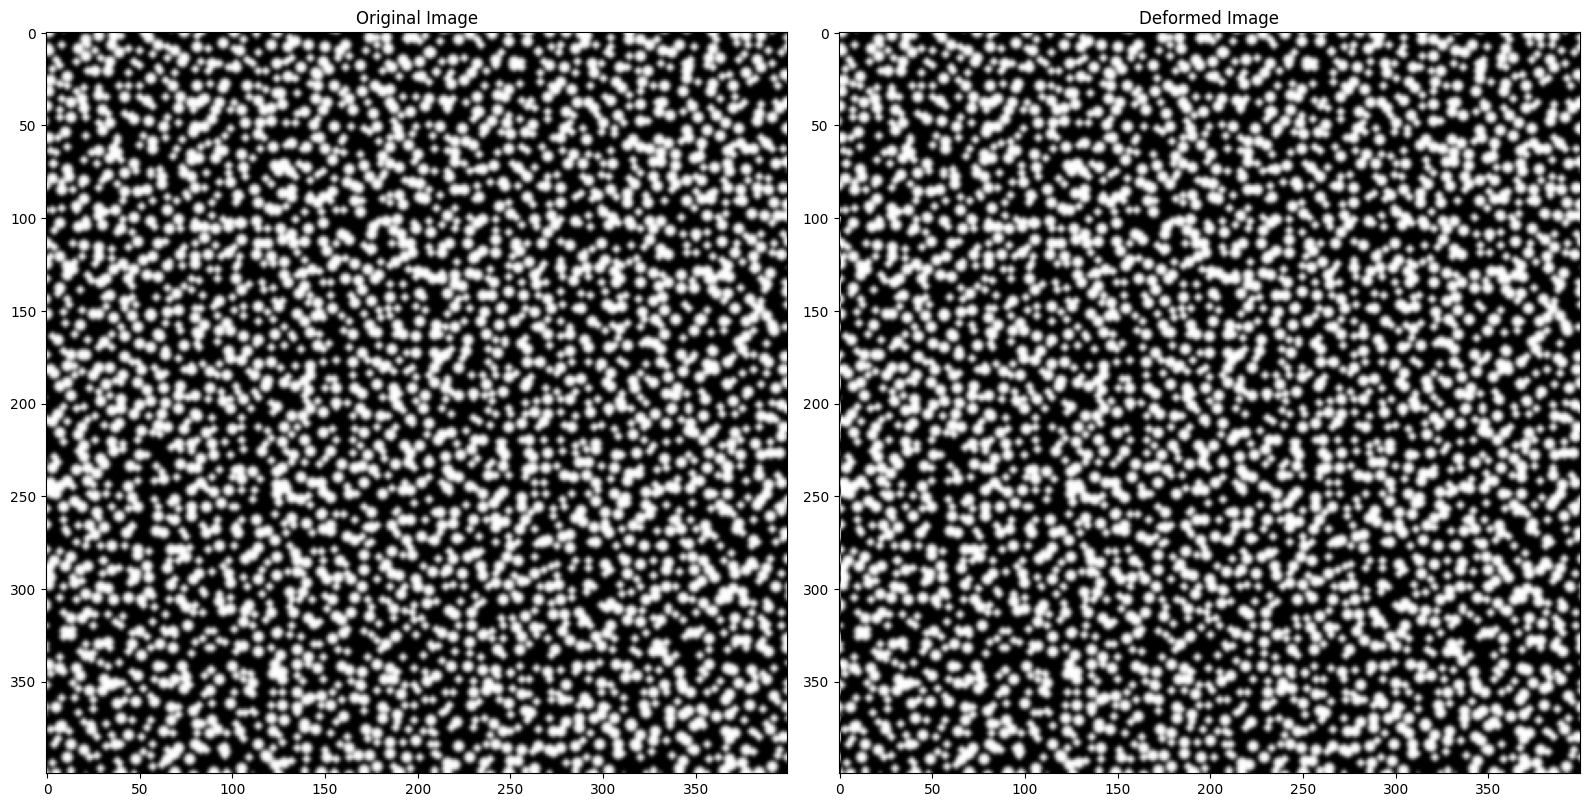

Searching for interpolated deformed subsets GLOBALLY in interpolated reference image using openCV                                                     :  35%|███▍      | 451/1296 [02:14<04:12,  3.35it/s]


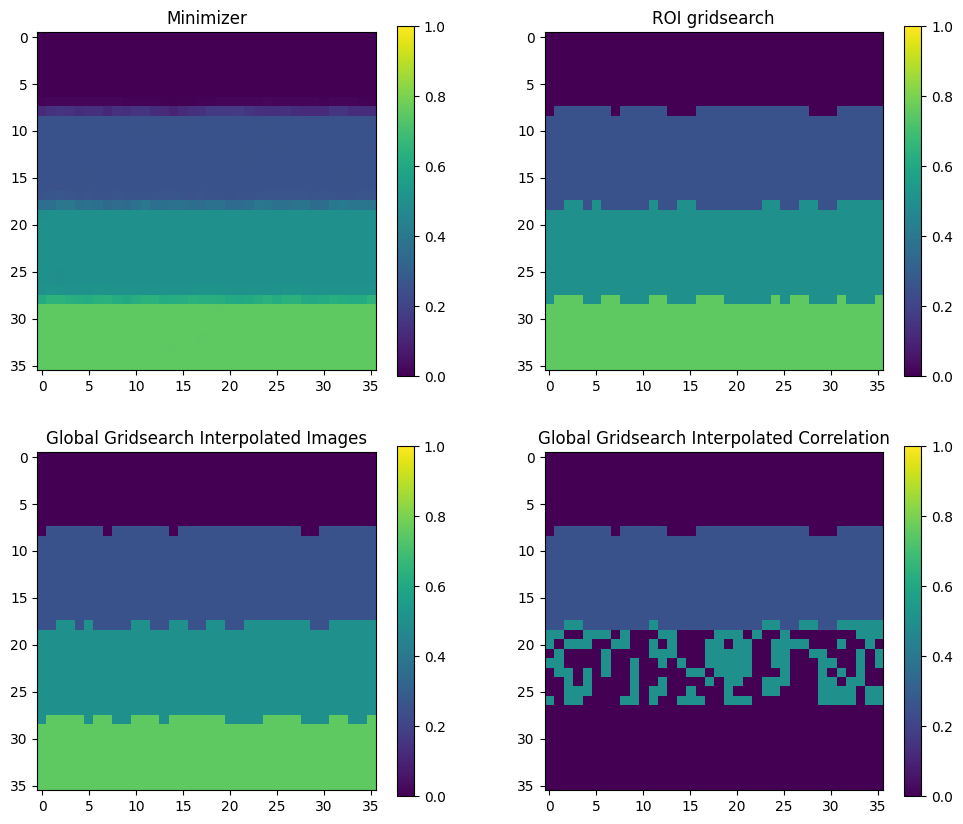

In [18]:


# figure debugging
fig, axes = plt.subplots(1, 2, figsize=(16,16)) 
axes[0].set_title("Original Image")
axes[1].set_title("Deformed Image")
axes[0].imshow(speckle_pattern, cmap="gray",vmin=0, vmax=255)
axes[1].imshow(deformed_pattern, cmap="gray",vmin=0, vmax=255)
plt.tight_layout()  

# figure debugging
fig1, axes1 = plt.subplots(2,2, figsize=(12,10)) 
axes1[0,0].set_title("Minimizer")
axes1[0,1].set_title("ROI gridsearch")
axes1[1,0].set_title("Global Gridsearch Interpolated Images")
axes1[1,1].set_title("Global Gridsearch Interpolated Correlation")
im1 = axes1[0, 0].imshow(u_arr1, cmap="viridis", vmin=0, vmax=1.0)
im2 = axes1[0, 1].imshow(u_arr2, cmap="viridis", vmin=0, vmax=1.0)
im3 = axes1[1, 0].imshow(u_arr3, cmap="viridis", vmin=0, vmax=1.0)
im4 = axes1[1, 1].imshow(u_arr4, cmap="viridis", vmin=0, vmax=1.0)
fig1.colorbar(im1, ax=axes1[0, 0], orientation='vertical')  # Colorbar for im1
fig1.colorbar(im2, ax=axes1[0, 1], orientation='vertical')  # Colorbar for im2
fig1.colorbar(im3, ax=axes1[1, 0], orientation='vertical')  # Colorbar for im3
fig1.colorbar(im4, ax=axes1[1, 1], orientation='vertical')  # Colorbar for im4  
plt.show()
